# Лабораторная работа 10

## Практика TensorFlow 2.x

Выполнил: гр. 6231, Габбасов Раиль

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST. Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов. Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API. Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

from tqdm import tqdm

In [2]:
tf.__version__

'2.9.2'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

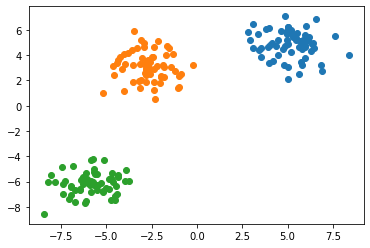

In [4]:
# 0.1

noise1 = tf.random.normal((64, 2), mean=[5, 5], stddev=1)
noise2 = tf.random.normal((64, 2), mean=[-3, 3], stddev=1)
noise3 = tf.random.normal((64, 2), mean=[-6, -6], stddev=1)

plt.scatter(noise1[:, 0], noise1[:, 1])
plt.scatter(noise2[:, 0], noise2[:, 1])
plt.scatter(noise3[:, 0], noise3[:, 1])

In [5]:
matrix = np.random.normal(size=(2,2))
matrix

array([[-0.02365888,  0.11301136],
       [-0.73033877,  0.69613969]])

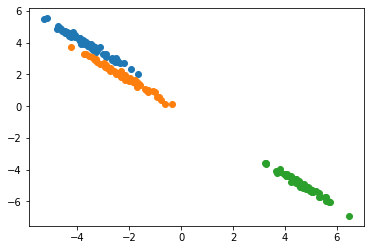

In [6]:
# 0.2

m_noise1 = tf.matmul(noise1, matrix)
m_noise2 = tf.matmul(noise2, matrix)
m_noise3 = tf.matmul(noise3, matrix)

plt.scatter(m_noise1[:, 0], m_noise1[:, 1])
plt.scatter(m_noise2[:, 0], m_noise2[:, 1])
plt.scatter(m_noise3[:, 0], m_noise3[:, 1])

1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

NUM_TRAIN = None  # 10000
NUM_TEST = None  # 1000

X_train = X_train[:NUM_TRAIN]
y_train = y_train[:NUM_TRAIN]

X_test = X_test[:NUM_TEST]
y_test = y_test[:NUM_TEST]

print(f"Тренировочный набор: X={X_train.shape}, y={y_train.shape}")
print(f"Тестовый набор данных: X={X_test.shape}, y={y_test.shape}")

Тренировочный набор: X=(60000, 28, 28), y=(60000,)
Тестовый набор данных: X=(10000, 28, 28), y=(10000,)


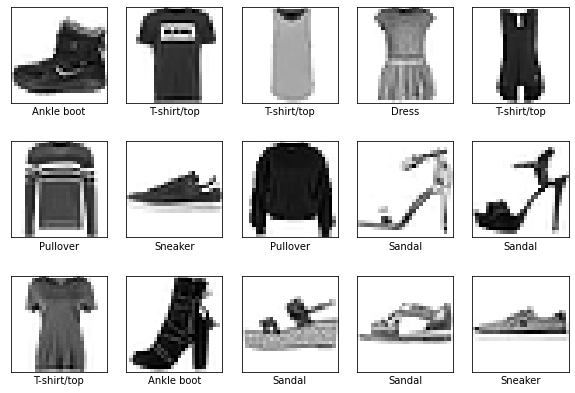

In [8]:
plt.figure(figsize=(10, 7))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [10]:
X_train.min(), X_train.max(), X_train.mean(), X_train.std()

(0.0, 255.0, 72.94042, 90.02121)

In [11]:
mean, std = np.mean(X_train), np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [12]:
X_train.min(), X_train.max(), X_train.mean(), X_train.std()

(-0.8102582, 2.0224075, -7.9631286e-07, 1.0000011)

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных. К обучающему датасету добавьте перемешивание (`.shuffle`). К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)

train_dataset = train_dataset.batch(128, drop_remainder=True)
test_dataset = test_dataset.batch(128, drop_remainder=True)

4 Напишите класс слоя `Flatten`, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от `tf.Module`. Для трансформации тензоров изображений использовать `tf.reshape`.

In [14]:
class Flatten(tf.Module):

    def __init__(self, name=None):
        super().__init__(name=name)

    def __call__(self, x):
        x_shape = tf.shape(x)

        if len(x_shape) == 1:
            new_shape = x_shape
        elif len(x_shape) == 2:
            new_shape = (1, tf.math.reduce_prod(x_shape))
        else:
            new_shape = (x_shape[0], tf.math.reduce_prod(x_shape[1:]))

        return tf.reshape(x, new_shape)

5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [15]:
class Linear(tf.Module):

    def __init__(self, in_d, out_d, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        # В случае с tf.Module вызывать конструктор родительского класса обязательно! 
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=0.01, dtype='float32')
        self.w = tf.Variable(w, name=f'{name + "_" if name is not None else ""}weights')
        b = tf.zeros(out_d, dtype='float32')
        self.b = tf.Variable(b, name=f'{name + "_" if name is not None else ""}bias')
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [16]:
class LogisticRegression(tf.Module):
    def __init__(self, flatten_dim, n_classes=10, name='logistic_regression'):
        super().__init__(name=name)

        self.flatten_layer = Flatten(name=f'{name}_flatten')
        self.linear_layer = Linear(flatten_dim, n_classes, name=f'{name}_linear')
    
    def __call__(self, x):
        x = self.flatten_layer(x)
        x = self.linear_layer(x)
        return tf.nn.softmax(x)

In [17]:
model = LogisticRegression(flatten_dim=np.prod(X_train.shape[1:]), n_classes=len(class_names))

In [18]:
preds = model(X_train[0:1])
preds

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.15477268, 0.09565181, 0.1128557 , 0.08382843, 0.09315006,
        0.10049833, 0.09450512, 0.11616927, 0.0943389 , 0.05422964]],
      dtype=float32)>

In [19]:
np.argmax(preds, axis=1), y_train[0:1]

(array([0]), array([9], dtype=uint8))

7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [20]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)


def evaluate(model, dataset):
    """
    Функция тестирования модели.
    """ 
    
    y_preds = []
    y_true = []

    for X_batch, y_batch in tqdm(dataset):
        preds = model(X_batch)
        preds = tf.argmax(preds, axis=-1)
        y_preds.append(preds)
        y_true.append(y_batch)
    
    y_preds = tf.concat(y_preds, axis=0)
    y_true = tf.concat(y_true, axis=0)

    return accuracy(tf.cast(y_true, 'int32'), tf.cast(y_preds, 'int32')).numpy()

8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [21]:
def train_step(model, data, optim, loss_f):
    """
    Функция, производящая один обучающий шаг.
    """
    with tf.GradientTape() as tape:
        # "Прогон" данных через модель и вычисление значения функции ошибки
        x, y = data
        preds = model(x)
        loss = loss_f(y, preds)
    # Вычисление градиентов
    grads = tape.gradient(loss, model.trainable_variables)
    # Применение градиентов к весам
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss

9 Оцените точность модели.

In [22]:
acc = evaluate(model, test_dataset)
print('\nAccuracy:', round(acc * 100, 2), '%')

100%|██████████| 78/78 [00:00<00:00, 113.17it/s]


Accuracy: 7.46 %


10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [23]:
print_period = 100

epochs = 10
# optim = tf.optimizers.RMSprop(learning_rate=0.01)
optim = tf.optimizers.Adam(learning_rate=0.005)
loss_f = tf.keras.losses.SparseCategoricalCrossentropy()

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [24]:
loss_history = []
acc_history = []

for epoch in range(epochs):

    for i, data in enumerate(train_dataset):

        loss = train_step(model, data, optim, loss_f)

        loss_numpy = loss.numpy()
        loss_history.append(loss_numpy)
        
        if i % print_period == 0:
            print('Epoch:', epoch, 'Iteration:', i, 'Loss:', loss_numpy)
    
    print('Тестирование модели...')
    acc = evaluate(model, test_dataset)
    acc_history.append(acc)
    print('Epoch:', epoch, 'Accuracy:', acc)

Epoch: 0 Iteration: 0 Loss: 2.3514032
Epoch: 0 Iteration: 100 Loss: 0.4244642
Epoch: 0 Iteration: 200 Loss: 0.45186418
Epoch: 0 Iteration: 300 Loss: 0.34093297
Epoch: 0 Iteration: 400 Loss: 0.6080115
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 256.96it/s]


Epoch: 0 Accuracy: 0.8318309
Epoch: 1 Iteration: 0 Loss: 0.49568298
Epoch: 1 Iteration: 100 Loss: 0.61734474
Epoch: 1 Iteration: 200 Loss: 0.49833992
Epoch: 1 Iteration: 300 Loss: 0.6577134
Epoch: 1 Iteration: 400 Loss: 0.42150545
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 368.78it/s]


Epoch: 1 Accuracy: 0.81540465
Epoch: 2 Iteration: 0 Loss: 0.50815207
Epoch: 2 Iteration: 100 Loss: 0.45082307
Epoch: 2 Iteration: 200 Loss: 0.44029844
Epoch: 2 Iteration: 300 Loss: 0.6022781
Epoch: 2 Iteration: 400 Loss: 0.44698194
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 427.90it/s]

Epoch: 2 Accuracy: 0.8322316


Epoch: 3 Iteration: 0 Loss: 0.3943576
Epoch: 3 Iteration: 100 Loss: 0.36284775
Epoch: 3 Iteration: 200 Loss: 0.3054235
Epoch: 3 Iteration: 300 Loss: 0.318746
Epoch: 3 Iteration: 400 Loss: 0.45736057
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 407.36it/s]


Epoch: 3 Accuracy: 0.82311696
Epoch: 4 Iteration: 0 Loss: 0.45537478
Epoch: 4 Iteration: 100 Loss: 0.50592005
Epoch: 4 Iteration: 200 Loss: 0.38637042
Epoch: 4 Iteration: 300 Loss: 0.5629841
Epoch: 4 Iteration: 400 Loss: 0.38583142
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 254.89it/s]


Epoch: 4 Accuracy: 0.80709136
Epoch: 5 Iteration: 0 Loss: 0.5082116
Epoch: 5 Iteration: 100 Loss: 0.36478066
Epoch: 5 Iteration: 200 Loss: 0.3567196
Epoch: 5 Iteration: 300 Loss: 0.6618944
Epoch: 5 Iteration: 400 Loss: 0.4165995
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 256.11it/s]


Epoch: 5 Accuracy: 0.82782453
Epoch: 6 Iteration: 0 Loss: 0.50833
Epoch: 6 Iteration: 100 Loss: 0.48484802
Epoch: 6 Iteration: 200 Loss: 0.26212966
Epoch: 6 Iteration: 300 Loss: 0.5534221
Epoch: 6 Iteration: 400 Loss: 0.49968818
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 451.57it/s]

Epoch: 6 Accuracy: 0.8171074


Epoch: 7 Iteration: 0 Loss: 0.35033917
Epoch: 7 Iteration: 100 Loss: 0.6206399
Epoch: 7 Iteration: 200 Loss: 0.61105406
Epoch: 7 Iteration: 300 Loss: 0.3833211
Epoch: 7 Iteration: 400 Loss: 0.33761287
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 490.12it/s]

Epoch: 7 Accuracy: 0.83153045


Epoch: 8 Iteration: 0 Loss: 0.3337804
Epoch: 8 Iteration: 100 Loss: 0.4960071
Epoch: 8 Iteration: 200 Loss: 0.35492435
Epoch: 8 Iteration: 300 Loss: 0.51865923
Epoch: 8 Iteration: 400 Loss: 0.6441467
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 252.48it/s]


Epoch: 8 Accuracy: 0.81270033
Epoch: 9 Iteration: 0 Loss: 0.37087107
Epoch: 9 Iteration: 100 Loss: 0.4364371
Epoch: 9 Iteration: 200 Loss: 0.31010896
Epoch: 9 Iteration: 300 Loss: 0.7429841
Epoch: 9 Iteration: 400 Loss: 0.4133262
Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 257.12it/s]

Epoch: 9 Accuracy: 0.81330127


12 Выведите графики точности и ошибки, используя matplotlib.

Loss


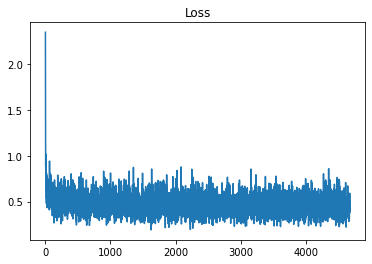

Accuracy


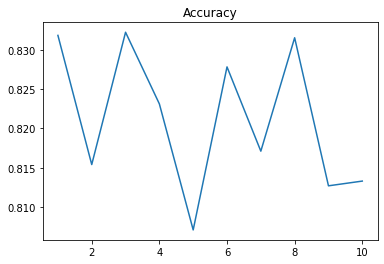

In [25]:
print('Loss')
plt.plot(loss_history)
plt.title("Loss")
plt.show()

print('Accuracy')
plt.plot(np.arange(epochs) + 1, acc_history)
plt.title("Accuracy")
plt.show()

13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи. 

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

In [27]:
keras_model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.15),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [28]:
loss = SparseCategoricalCrossentropy()
accuracy = SparseCategoricalAccuracy()
optim = Adam(lr=0.01)

epochs = 5

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
keras_model.compile(optimizer=optim, loss=loss, metrics=[accuracy])

In [30]:
info = keras_model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/5
468/468 [==============================] - 33s 70ms/step - loss: 0.4466 - sparse_categorical_accuracy: 0.8438 - val_loss: 0.3556 - val_sparse_categorical_accuracy: 0.8730
Epoch 2/5
468/468 [==============================] - 30s 64ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.8897 - val_loss: 0.3225 - val_sparse_categorical_accuracy: 0.8848
Epoch 3/5
468/468 [==============================] - 30s 63ms/step - loss: 0.2794 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.2988 - val_sparse_categorical_accuracy: 0.8953
Epoch 4/5
468/468 [==============================] - 29s 62ms/step - loss: 0.2613 - sparse_categorical_accuracy: 0.9026 - val_loss: 0.3060 - val_sparse_categorical_accuracy: 0.8952
Epoch 5/5
468/468 [==============================] - 29s 62ms/step - loss: 0.2471 - sparse_categorical_accuracy: 0.9088 - val_loss: 0.3128 - val_sparse_categorical_accuracy: 0.8898


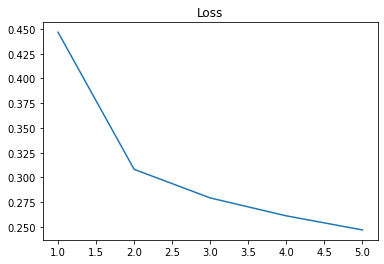

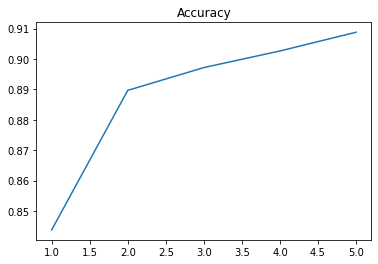

In [31]:
plt.plot(np.arange(epochs) + 1, info.history['loss'])
plt.title("Loss")
plt.show()

plt.plot(np.arange(epochs) + 1, info.history['sparse_categorical_accuracy'])
plt.title("Accuracy")
plt.show()

Вывод: Построенная модель свёрточной нейронной сети справляется с задачей классификации изображений лучше, чем простейшая логистическая регрессия с уплощением картинки - даже с обучением на меньшем количестве эпох достигается большая accuracy, а само обучение происходит стабильнее (график лосса регрессии гораздо шумнее).